### Install packages

In [1]:
%pip install -q pypandoc docx2txt PyPDF2 openpyxl python-dotenv openai num2words matplotlib plotly scipy scikit-learn pandas tiktoken ipywidgets seaborn
%load_ext dotenv
%dotenv

Note: you may need to restart the kernel to use updated packages.


Extract all submissions to a tmp folder


In [2]:
# Import the zipfile module
from zipfile import ZipFile
# Create a zip file object using ZipFile class
with ZipFile("data/submission.zip", "r") as zip_obj:
    # Extract all the files into a directory
    zip_obj.extractall("tmp/") 

In [3]:
# Import the os module
import os
import pandas as pd

# Define the path to list
temp_path = "tmp/submission/"

def is_folder_contains_file(folder_path, extension): 
    # Get a list of all files and directories in the path 
    names = os.listdir(folder_path) 
    for name in names: 
        if name.endswith(extension): 
            return True 
    return False   
    
# Get a list of all files and directories in the path
def get_submissions_df(path):
    assignment_folders = []
    names = os.listdir(path)
    # Loop through the list
    for name in names:
        # Join the path and the name
        full_path = os.path.join(path, name)
        # Check if it is a directory
        if os.path.isdir(full_path):
            # Print the directory name
            assignment_folders.append({
                "Student": name.split("_")[0],
                "Path": full_path,
                "ContainsDocxFile": is_folder_contains_file(full_path, ".docx"),                
                "ContainsPdfFile": is_folder_contains_file(full_path, ".pdf"),
                "ContainsZipFile": is_folder_contains_file(full_path, ".zip")
                })
    df = pd.DataFrame([p for p in assignment_folders])
    return df
df = get_submissions_df(temp_path)

In [4]:
df

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile
0,NG Man Hei,tmp/submission/NG Man Hei_2461662_assignsubmis...,False,True,False
1,LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False
2,CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False
3,NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False
4,CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False
...,...,...,...,...,...
67,HUI Man Chun,tmp/submission/HUI Man Chun_2461600_assignsubm...,True,False,False
68,CHEUNG Ka Kwai,tmp/submission/CHEUNG Ka Kwai_2461642_assignsu...,True,False,False
69,LAU Yuen Ting,tmp/submission/LAU Yuen Ting_2461612_assignsub...,True,False,False
70,LI Hoi Yung,tmp/submission/LI Hoi Yung_2461659_assignsubmi...,True,False,False


### Check any invalid submission files

In [5]:
def filter_df_by_not_contains_any_expected_files(df):
    return df[(df["ContainsDocxFile"] == False) & (df["ContainsPdfFile"] == False) & (df["ContainsZipFile"] == False)]
filter_df_by_not_contains_any_expected_files(df)

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile


Handle zip file.

In [6]:
import os
import shutil

def flatten(directory):
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(directory, filename)

            while os.path.exists(target):
                i += 1
                file_parts = os.path.splitext(os.path.basename(filename))

                target = os.path.join(
                    directory,
                    file_parts[0] + "_" + str(i) + file_parts[1],
                )

            shutil.move(source, target)

            print("Moved ", source, " to ", target)

        if dirpath != directory:
            os.rmdir(dirpath)
            print("Deleted ", dirpath)

def get_first_file_path(path, ext):
    names = os.listdir(path)
    for name in names:
        if name.endswith(ext):
            return os.path.join(path, name)

def extract_zip_file_in_place(path):
    zip_path = get_first_file_path(path, ".zip")
    print(zip_path)
    import zipfile
    # Create a zip file object using ZipFile class
    with zipfile.ZipFile(zip_path, "r") as zip_obj:
        # Extract all the files into a directory
        zip_obj.extractall(path)
    flatten(path) 


def filter_df_by_contains_zip_file(df):
    return df[(df["ContainsZipFile"] == True)]

paths = filter_df_by_contains_zip_file(df)["Path"].values
for path in paths:
    extract_zip_file_in_place(path)

tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456_1_1_1_1_1_1.zip
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_Writing_1.docx  to  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_Writing_1_2.docx
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456_1_1_1_1_1_1.zip  to  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456_1_1_1_1_1_1_1.zip
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456.zip  to  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_KanNinChun_210226456_1.zip
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_VideoLink_1.docx  to  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_VideoLink_1_2.docx
Moved  tmp/submission/KAN Nin Chun_2461630_assignsubmission_file_/EA3_210226456_VideoLink_1_1.docx  to  tmp/subm

In [7]:
df = get_submissions_df(temp_path)
## check all rows contains Docx or PDF file
def filter_df_by_contains_docx_or_pdf_file(df):
    return df[(df["ContainsDocxFile"] == True) | (df["ContainsPdfFile"] == True)]

filter_df_by_contains_docx_or_pdf_file(df)

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile
0,NG Man Hei,tmp/submission/NG Man Hei_2461662_assignsubmis...,False,True,False
1,LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False
2,CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False
3,NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False
4,CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False
...,...,...,...,...,...
67,HUI Man Chun,tmp/submission/HUI Man Chun_2461600_assignsubm...,True,False,False
68,CHEUNG Ka Kwai,tmp/submission/CHEUNG Ka Kwai_2461642_assignsu...,True,False,False
69,LAU Yuen Ting,tmp/submission/LAU Yuen Ting_2461612_assignsub...,True,False,False
70,LI Hoi Yung,tmp/submission/LI Hoi Yung_2461659_assignsubmi...,True,False,False


## Processing Docx files

In [8]:
def filter_df_by_contains_docx(df):
    return df[(df["ContainsDocxFile"] == True)]
words_df = filter_df_by_contains_docx(df)
paths = words_df["Path"].values

def get_all_docx_files(path):
    import glob
    return glob.glob(path + "/*.docx")

import docx2txt
from functools import reduce

students_words_files = list(map(get_all_docx_files, paths)) # List of lists of word files

file_contents =[];
for word_files in students_words_files:  
    file_contents.append(reduce(lambda x, y: x + y, map(lambda f: docx2txt.process(f), word_files), "\n\n"))
# reduce(map(lambda f: docx2txt.process(f), word_files), lambda x, y: x + y, "")
words_df.loc[:, "Sources"] = students_words_files
words_df.loc[:, "Answers"] = file_contents


/tmp/ipykernel_21503/1956843748.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words_df.loc[:, "Sources"] = students_words_files
/tmp/ipykernel_21503/1956843748.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words_df.loc[:, "Answers"] = file_contents


In [9]:
def filter_df_by_contains_pdf(df):
    return df[(df["ContainsPdfFile"] == True)]
pdfs_df = filter_df_by_contains_pdf(df)
paths = pdfs_df["Path"].values

def get_add_pdf_files(path):
    import glob
    return glob.glob(path + "/*.pdf")

import PyPDF2
from functools import reduce

def convert_pdf_all_pages_to_txt(path):
    pdfFileObj = open(path, 'rb')
    reader = PyPDF2.PdfReader(pdfFileObj)
    num_pages = len(reader.pages)
    count = 0
    text = ""
    while count < num_pages:
        pageObj = reader.pages[count]
        count += 1
        text += pageObj.extract_text()
        text += "\n\n"
    return text

students_pdf_files = list(map(get_add_pdf_files, paths)) # List of lists of word files

file_contents =[];
for pdf_files in students_pdf_files:
    file_contents.append(reduce(lambda x, y: x + y, map(convert_pdf_all_pages_to_txt, pdf_files), "\n\n"))

pdfs_df.loc[:, "Sources"] = students_pdf_files
pdfs_df.loc[:, "Answers"] = file_contents
pdfs_df


/tmp/ipykernel_21503/333760499.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdfs_df.loc[:, "Sources"] = students_pdf_files
/tmp/ipykernel_21503/333760499.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdfs_df.loc[:, "Answers"] = file_contents


,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers
0,NG Man Hei,tmp/submission/NG Man Hei_2461662_assignsubmis...,False,True,False,[tmp/submission/NG Man Hei_2461662_assignsubmi...,"\n\nAs a system engineer, my job responsibilit..."
8,FU Kit Lun,tmp/submission/FU Kit Lun_2461636_assignsubmis...,False,True,False,[tmp/submission/FU Kit Lun_2461636_assignsubmi...,\n\nI T P 4 1 2 1\nC l o u d\na n d\nD a t a\n...
19,KWAN Wan Loi,tmp/submission/KWAN Wan Loi_2461627_assignsubm...,True,True,False,[tmp/submission/KWAN Wan Loi_2461627_assignsub...,\n\nName: Kwan Wan Loi\nStudent id:210092959\n...
20,LO Fu Hon,tmp/submission/LO Fu Hon_2461619_assignsubmiss...,True,True,False,[tmp/submission/LO Fu Hon_2461619_assignsubmis...,\n\nJob Responsibility and Roles \nI am respo...
31,NAWAZ Raheem,tmp/submission/NAWAZ Raheem_2461598_assignsubm...,False,True,False,[tmp/submission/NAWAZ Raheem_2461598_assignsub...,"\n\nAs an intern at GTI, my role as a System A..."
45,CHONG Ka Fai,tmp/submission/CHONG Ka Fai_2461660_assignsubm...,False,True,False,[tmp/submission/CHONG Ka Fai_2461660_assignsub...,\n\nI will focus on the following items for th...
49,ZENG Haoxuan,tmp/submission/ZENG Haoxuan_2461633_assignsubm...,True,True,False,[tmp/submission/ZENG Haoxuan_2461633_assignsub...,\n\nITP4121 -Assignment -EA3 ...
54,LEE Kai,tmp/submission/LEE Kai_2461644_assignsubmissio...,False,True,False,[tmp/submission/LEE Kai_2461644_assignsubmissi...,\n\n\n\n\n\n\n\n\n\n


In [10]:
# combine two dataframes into one and export to excel
df_answers = pd.concat([words_df, pdfs_df])
df_answers.to_excel("data/answers.xlsx", index=False)

In [11]:
df_answers.head(1)["Answers"].values[0]

'\n\nITP4121 Workplace Reflective Journal\n\nLeung Chun Wa   /   210163465\n\n\n\nTable of contents\n\nJob Responsibility and Roles\n\nWorkplace experience\n\nLearning in Workplace\n\nComments on Workplace and Suggestions\n\nAbout WLA\n\nEvaluation\n\nCareer Path\n\n\n\nJob Responsibility and Roles\n\nAs an IT support team intern at Master Concept, my job responsibilities include the following.\n\n\n\nMaintaining IT equipment\n\nI am responsible for setting up and configuring new equipment, like computers, monitors, and other devices in the office. Also include setting up the equipment needed for some project, for example, HKEAA DSE related works.\n\n\n\nManaging user accounts\n\nCreating and managing user accounts for projects, which involves setting up new accounts, disabling old accounts, and managing access permissions. I assisted in this area for OpenData Hackathon 2022.\n\n\n\nManaging help desk services\n\nI need to call our own outsourced help desk, ensuring that the service qu

## Using Azure OpenAI ChatGPT to grade student answers

In [12]:
import os
import json
import openai
openai.api_type = "azure"
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT") 
openai.api_version = "2023-03-15-preview"
openai.api_key = os.getenv("AZURE_OPENAI_KEY")

# read text file and return the content
def read_text_file(path):
    with open(path, 'r') as file:
        data = file.read().replace('\n', '')
    return data

def grade_answer(student_answer, marking_scheme):
    prompt=marking_scheme.replace("<ANSWER></ANSWER>", student_answer)
    try:
        response = openai.ChatCompletion.create(
            engine="gpt-35-turbo", # engine = "deployment_name".
            messages=[
                {"role": "system", "content": "You are a teaching assistant."},
                {"role": "user", "content": prompt},      
            ]
        )
        print(response)
        print(response['choices'][0]['message']['content'])        
        tokens = response['usage']['total_tokens']
        content = json.loads(response['choices'][0]['message']['content'])
        marks = content['marks']
        comments = content['comments']
        details = content['details']
        copyFromInternet = content['copyFromInternet']
        generativeAI = content['generativeAI']
        return marks, comments, details, copyFromInternet, generativeAI, tokens, False
    except Exception as e:
        print(e)
        return 0, "Error", [], 0, 0, 0, True



def grade_answers(df_answers, marking_scheme):
    for index, row in df_answers.iterrows():      
        student = row["Student"]
        print(student)
        answer = row["Answers"]
        marks, comments, details, copyFromInternet, generativeAI, tokens, error = grade_answer(answer, marking_scheme)
        df_answers.loc[index, "Marks"] = marks
        df_answers.loc[index, "Comments"] = comments
        df_answers.loc[index, "Details"] = "\n".join(list(map(lambda x: x["task"] + ": " + str(x["marks"]) +" marks\n"+ x["comments"], details)))
        df_answers.loc[index, "CopyFromInternet"] = copyFromInternet
        df_answers.loc[index, "GenerativeAI"] = generativeAI
        df_answers.loc[index, "ChatGptTokens"] = tokens
        df_answers.loc[index, "Error"] = error
    return df_answers

marking_scheme = read_text_file("marking_scheme.txt")

# get second row answer for df_answers
# student = df_answers.iloc[[2]]["Student"].values[0]
# student_answer = df_answers.iloc[[2]]["Answers"].values[0]
# print(student_answer)
# grade_answer(student_answer, marking_scheme)

df_marked = grade_answers(df_answers.head(10), marking_scheme)
df_marked.to_excel("data/marks.xlsx", index=False)

LEUNG Chun Wa
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "{\n    \"marks\": 65,\n    \"comments\": \"Good job overall! You have demonstrated a good understanding of your job responsibilities and the skills you have learned in the workplace. Your workplace experience is also well described, and your suggestions for improvement are constructive. However, there are areas where you could improve, such as providing more detailed information on your learning in the workplace and how it relates to the Higher Diploma in Cloud & Data Center Administration program. Additionally, it would be beneficial to provide more specific examples of your achievements in the workplace. Keep up the good work and keep striving for improvement!\",\n    \"details\":[\n        {\"task\": \"1. Job Responsibility and Roles\", \"marks\": 6, \"comments\":\"Good job on describing your job responsibilities. However, more specific examples could have bee

/tmp/ipykernel_21503/2557224078.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_answers.loc[index, "Marks"] = marks
/tmp/ipykernel_21503/2557224078.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_answers.loc[index, "Comments"] = comments
/tmp/ipykernel_21503/2557224078.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "{\n    \"marks\": 65,\n    \"comments\": \"Good job overall! Keep up the good work and try to focus on improving the areas where you have given yourself lower marks.\",\n    \"details\":[\n        {\"task\": \"1. Job Responsibility and Roles\", \"marks\": 5, \"comments\":\"Good explanation of job duties, but could have provided more detail and examples. Consider taking a more proactive approach to your role.\"},\n        {\"task\": \"2. Workplace experience\", \"marks\": 10, \"comments\":\"Great job detailing your experiences in the workplace. Your memorable experience was a good example of how you are getting involved in different projects.\"},\n        {\"task\": \"3. Learning in Workplace\", \"marks\": 8, \"comments\":\"Good examples of hardware and software skills learned, but could have provided more detail on soft skills. Communication is an important skill to mention, b

In [13]:
df_marked

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers,Marks,Comments,Details,CopyFromInternet,GenerativeAI,ChatGptTokens,Error
1,LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False,[tmp/submission/LEUNG Chun Wa_2461652_assignsu...,\n\nITP4121 Workplace Reflective Journal\n\nLe...,65.0,Good job overall! You have demonstrated a good...,1. Job Responsibility and Roles: 6 marks\nGood...,0.20,0.1,1872.0,False
2,CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False,[tmp/submission/CHEUNG Chi Him_2461641_assigns...,\n\nJob Responsibility and Roles\n\nWorkplace ...,65.0,Good job overall! Keep up the good work and tr...,1. Job Responsibility and Roles: 5 marks\nGood...,0.10,0.1,2385.0,False
3,NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False,[tmp/submission/NG Man Chun_2461585_assignsubm...,\n\nITP4121 Cloud and Data Centre Workplace Pr...,65.0,Good job overall! Your reflective journal is w...,1. Job Responsibility and Roles: 8 marks\nYou ...,0.05,0.1,2798.0,False
4,CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False,[tmp/submission/CHAN Hiu Po_2461655_assignsubm...,\n\nChan HiuPo 210151024\n\n\n\nTable of conte...,60.0,"Good effort, keep up the hard work!",1. Job Responsibility and Roles: 7 marks\nGood...,0.10,0.0,2003.0,False
5,IP Siu Fung Ernest,tmp/submission/IP Siu Fung Ernest_2461586_assi...,True,False,False,[tmp/submission/IP Siu Fung Ernest_2461586_ass...,\n\nIP Siu Fung Ernest (210123688)\n\nIT114115...,63.0,Well done on providing detailed answers and ex...,1. Job Responsibility and Roles: 8 marks\nYour...,0.05,0.1,2512.0,False
6,CHENG Sin On,tmp/submission/CHENG Sin On_2461588_assignsubm...,True,False,False,[tmp/submission/CHENG Sin On_2461588_assignsub...,\n\nIntroduction\n\nI have joined the Microsof...,0.0,Error,,0.00,0.0,0.0,True
7,LIU Ka Kwan,tmp/submission/LIU Ka Kwan_2461638_assignsubmi...,True,False,False,[tmp/submission/LIU Ka Kwan_2461638_assignsubm...,\n\nWorkplace Reflective Journal\n\n\n\nJob Re...,68.0,Great job overall! Your response shows that yo...,1. Job Responsibility and Roles: 9 marks\nYour...,0.00,0.0,2154.0,False
9,ZHANG Jinwei,tmp/submission/ZHANG Jinwei_2461645_assignsubm...,True,False,False,[tmp/submission/ZHANG Jinwei_2461645_assignsub...,\n\nWorkplace Reflection Diary of IT Network M...,0.0,Error,,0.00,0.0,0.0,True
10,WONG Kam Shing,tmp/submission/WONG Kam Shing_2461628_assignsu...,True,False,False,[tmp/submission/WONG Kam Shing_2461628_assigns...,\n\nhttps://youtu.be/xdWe_QkX2aEAs a student w...,69.0,Great job overall! You have provided a detaile...,1. Job Responsibility and Roles: 9 marks\nWell...,0.10,0.1,2556.0,False
11,TO Lon San,tmp/submission/TO Lon San_2461657_assignsubmis...,True,False,False,[tmp/submission/TO Lon San_2461657_assignsubmi...,\n\nTo Lon San 210275438\n\nAs a System Engine...,65.0,Great job! You have provided comprehensive ans...,1. Job Responsibility and Roles: 7 marks\nYour...,0.10,0.1,2099.0,False


### Embeddings and clustering

In [14]:
import openai
import os
import re
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding
import tiktoken

API_KEY = os.getenv("AZURE_OPENAI_KEY") 
RESOURCE_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") 

openai.api_type = "azure"
openai.api_key = API_KEY
openai.api_base = RESOURCE_ENDPOINT
openai.api_version = "2022-12-01"

url = openai.api_base + "/openai/deployments?api-version=2022-12-01" 

In [15]:
df_marked = pd.read_excel("data/marks.xlsx") 
df_Answers = df_marked[['Student','Answers']]
df_Answers

,Student,Answers
0,LEUNG Chun Wa,\n\nITP4121 Workplace Reflective Journal\n\nLe...
1,CHEUNG Chi Him,\n\nJob Responsibility and Roles\n\nWorkplace ...
2,NG Man Chun,\n\nITP4121 Cloud and Data Centre Workplace Pr...
3,CHAN Hiu Po,\n\nChan HiuPo 210151024\n\n\n\nTable of conte...
4,IP Siu Fung Ernest,\n\nIP Siu Fung Ernest (210123688)\n\nIT114115...
5,CHENG Sin On,\n\nIntroduction\n\nI have joined the Microsof...
6,LIU Ka Kwan,\n\nWorkplace Reflective Journal\n\n\n\nJob Re...
7,ZHANG Jinwei,\n\nWorkplace Reflection Diary of IT Network M...
8,WONG Kam Shing,\n\nhttps://youtu.be/xdWe_QkX2aEAs a student w...
9,TO Lon San,\n\nTo Lon San 210275438\n\nAs a System Engine...


Data cleaning by removing redundant whitespace and cleaning up

In [16]:
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

# s is input text
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()    
    return s

df_Answers['Answers']= df_Answers["Answers"].apply(lambda x : normalize_text(x))

Remove any answers that are too long for the token limit (8192 tokens).

In [17]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df_Answers['n_tokens'] = df_Answers["Answers"].apply(lambda x: len(tokenizer.encode(x)))
df_Answers = df_Answers[df_Answers.n_tokens<8192]
len(df_Answers)

10

In [18]:
df_Answers['ada_v2'] = df_Answers["Answers"].apply(lambda x : get_embedding(x, engine = 'text-embedding-ada-002')) 
df_Answers.set_index( ['Student'], inplace = True)
# engine should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model

In [19]:
df_Answers.to_excel("data/embeddings.xlsx", index=False)
df_Answers
df_Answers["ada_v2"]

Student
LEUNG Chun Wa         [0.010281223803758621, -0.010676655918359756, ...
CHEUNG Chi Him        [-0.012838901951909065, -0.027127781882882118,...
NG Man Chun           [0.007017713040113449, -0.02948104590177536, 0...
CHAN Hiu Po           [0.002446548081934452, -0.003825077321380377, ...
IP Siu Fung Ernest    [0.002623006235808134, -0.015880554914474487, ...
CHENG Sin On          [-0.01881338655948639, -0.040425676852464676, ...
LIU Ka Kwan           [-0.013472980819642544, -0.013459849171340466,...
ZHANG Jinwei          [-0.008594824932515621, 0.0051575591787695885,...
WONG Kam Shing        [-0.010748444125056267, -0.03343672677874565, ...
TO Lon San            [-0.011265682987868786, -0.013975824229419231,...
Name: ada_v2, dtype: object

### Clustering based on the Embeddings

Reload embeddings.

In [20]:
df_embeddings = df_Answers

In [21]:
from sklearn.cluster import KMeans

matrix = np.array(df_embeddings["ada_v2"].to_list())
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init='auto')
kmeans.fit(matrix)
labels = kmeans.labels_
df_embeddings["Cluster"] = labels 

/tmp/ipykernel_21503/2765499575.py:19: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/home/codespace/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_21503/2765499575.py:20: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


Text(0.5, 1.0, 'Embeddings visualized using t-SNE')

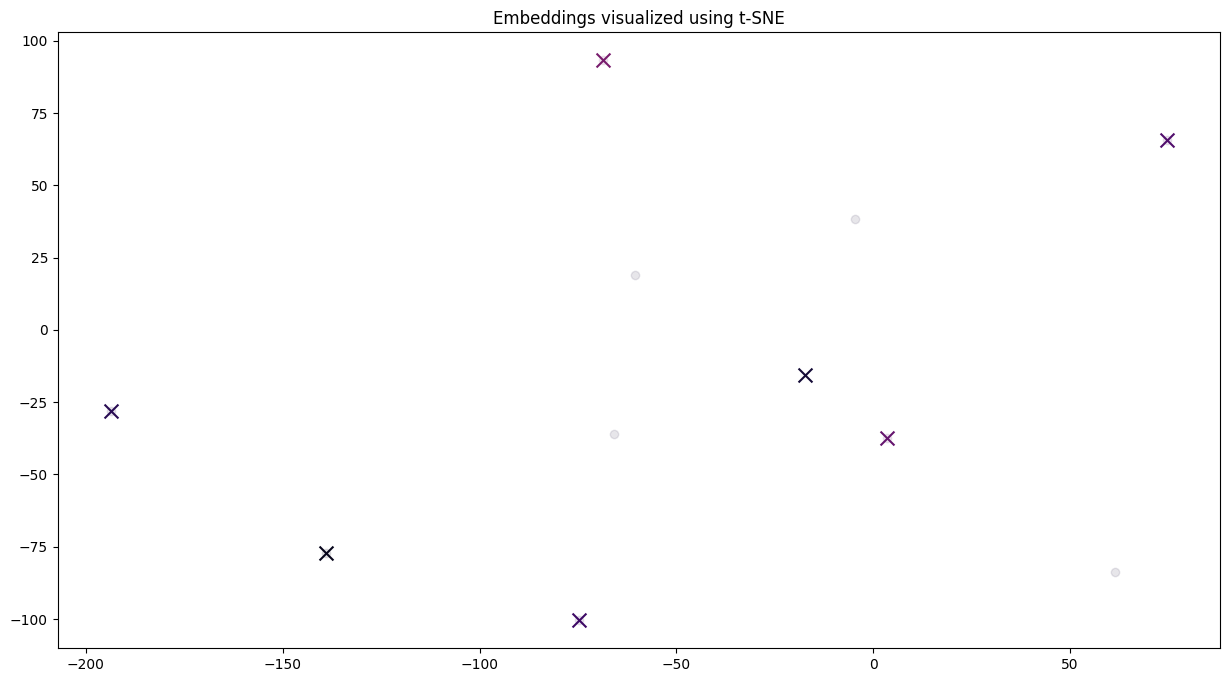

In [22]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 8) 

tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

palette = sns.color_palette("inferno", 20).as_hex() 

for category, color in enumerate(palette):
    xs = np.array(x)[df_embeddings["Cluster"]==category]
    ys = np.array(y)[df_embeddings["Cluster"]==category]
    plt.scatter(xs, ys, color=color, alpha=0.1)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)
plt.title("Embeddings visualized using t-SNE")

In [23]:
df_marked.set_index( ['Student'], inplace = True)
df_final = pd.merge(df_marked,df_embeddings[["n_tokens","ada_v2","Cluster"]], on=df_marked.index)
df_final.to_excel("data/clustered.xlsx", index=False)

In [24]:
df_marked


,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers,Marks,Comments,Details,CopyFromInternet,GenerativeAI,ChatGptTokens,Error
Student,,,,,,,,,,,,,
LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False,['tmp/submission/LEUNG Chun Wa_2461652_assigns...,\n\nITP4121 Workplace Reflective Journal\n\nLe...,65,Good job overall! You have demonstrated a good...,1. Job Responsibility and Roles: 6 marks\nGood...,0.20,0.1,1872,False
CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False,['tmp/submission/CHEUNG Chi Him_2461641_assign...,\n\nJob Responsibility and Roles\n\nWorkplace ...,65,Good job overall! Keep up the good work and tr...,1. Job Responsibility and Roles: 5 marks\nGood...,0.10,0.1,2385,False
NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False,['tmp/submission/NG Man Chun_2461585_assignsub...,\n\nITP4121 Cloud and Data Centre Workplace Pr...,65,Good job overall! Your reflective journal is w...,1. Job Responsibility and Roles: 8 marks\nYou ...,0.05,0.1,2798,False
CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False,['tmp/submission/CHAN Hiu Po_2461655_assignsub...,\n\nChan HiuPo 210151024\n\n\n\nTable of conte...,60,"Good effort, keep up the hard work!",1. Job Responsibility and Roles: 7 marks\nGood...,0.10,0.0,2003,False
IP Siu Fung Ernest,tmp/submission/IP Siu Fung Ernest_2461586_assi...,True,False,False,['tmp/submission/IP Siu Fung Ernest_2461586_as...,\n\nIP Siu Fung Ernest (210123688)\n\nIT114115...,63,Well done on providing detailed answers and ex...,1. Job Responsibility and Roles: 8 marks\nYour...,0.05,0.1,2512,False
CHENG Sin On,tmp/submission/CHENG Sin On_2461588_assignsubm...,True,False,False,['tmp/submission/CHENG Sin On_2461588_assignsu...,\n\nIntroduction\n\nI have joined the Microsof...,0,Error,NaN,0.00,0.0,0,True
LIU Ka Kwan,tmp/submission/LIU Ka Kwan_2461638_assignsubmi...,True,False,False,['tmp/submission/LIU Ka Kwan_2461638_assignsub...,\n\nWorkplace Reflective Journal\n\n\n\nJob Re...,68,Great job overall! Your response shows that yo...,1. Job Responsibility and Roles: 9 marks\nYour...,0.00,0.0,2154,False
ZHANG Jinwei,tmp/submission/ZHANG Jinwei_2461645_assignsubm...,True,False,False,['tmp/submission/ZHANG Jinwei_2461645_assignsu...,\n\nWorkplace Reflection Diary of IT Network M...,0,Error,NaN,0.00,0.0,0,True
WONG Kam Shing,tmp/submission/WONG Kam Shing_2461628_assignsu...,True,False,False,['tmp/submission/WONG Kam Shing_2461628_assign...,\n\nhttps://youtu.be/xdWe_QkX2aEAs a student w...,69,Great job overall! You have provided a detaile...,1. Job Responsibility and Roles: 9 marks\nWell...,0.10,0.1,2556,False


In [25]:
df_final

,key_0,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers,Marks,Comments,Details,CopyFromInternet,GenerativeAI,ChatGptTokens,Error,n_tokens,ada_v2,Cluster
0,LEUNG Chun Wa,tmp/submission/LEUNG Chun Wa_2461652_assignsub...,True,False,False,['tmp/submission/LEUNG Chun Wa_2461652_assigns...,\n\nITP4121 Workplace Reflective Journal\n\nLe...,65,Good job overall! You have demonstrated a good...,1. Job Responsibility and Roles: 6 marks\nGood...,0.20,0.1,1872,False,655,"[0.010281223803758621, -0.010676655918359756, ...",1
1,CHEUNG Chi Him,tmp/submission/CHEUNG Chi Him_2461641_assignsu...,True,False,False,['tmp/submission/CHEUNG Chi Him_2461641_assign...,\n\nJob Responsibility and Roles\n\nWorkplace ...,65,Good job overall! Keep up the good work and tr...,1. Job Responsibility and Roles: 5 marks\nGood...,0.10,0.1,2385,False,1237,"[-0.012838901951909065, -0.027127781882882118,...",1
2,NG Man Chun,tmp/submission/NG Man Chun_2461585_assignsubmi...,True,False,False,['tmp/submission/NG Man Chun_2461585_assignsub...,\n\nITP4121 Cloud and Data Centre Workplace Pr...,65,Good job overall! Your reflective journal is w...,1. Job Responsibility and Roles: 8 marks\nYou ...,0.05,0.1,2798,False,1532,"[0.007017713040113449, -0.02948104590177536, 0...",1
3,CHAN Hiu Po,tmp/submission/CHAN Hiu Po_2461655_assignsubmi...,True,False,False,['tmp/submission/CHAN Hiu Po_2461655_assignsub...,\n\nChan HiuPo 210151024\n\n\n\nTable of conte...,60,"Good effort, keep up the hard work!",1. Job Responsibility and Roles: 7 marks\nGood...,0.10,0.0,2003,False,986,"[0.002446548081934452, -0.003825077321380377, ...",6
4,IP Siu Fung Ernest,tmp/submission/IP Siu Fung Ernest_2461586_assi...,True,False,False,['tmp/submission/IP Siu Fung Ernest_2461586_as...,\n\nIP Siu Fung Ernest (210123688)\n\nIT114115...,63,Well done on providing detailed answers and ex...,1. Job Responsibility and Roles: 8 marks\nYour...,0.05,0.1,2512,False,1307,"[0.002623006235808134, -0.015880554914474487, ...",3
5,CHENG Sin On,tmp/submission/CHENG Sin On_2461588_assignsubm...,True,False,False,['tmp/submission/CHENG Sin On_2461588_assignsu...,\n\nIntroduction\n\nI have joined the Microsof...,0,Error,NaN,0.00,0.0,0,True,990,"[-0.01881338655948639, -0.040425676852464676, ...",1
6,LIU Ka Kwan,tmp/submission/LIU Ka Kwan_2461638_assignsubmi...,True,False,False,['tmp/submission/LIU Ka Kwan_2461638_assignsub...,\n\nWorkplace Reflective Journal\n\n\n\nJob Re...,68,Great job overall! Your response shows that yo...,1. Job Responsibility and Roles: 9 marks\nYour...,0.00,0.0,2154,False,990,"[-0.013472980819642544, -0.013459849171340466,...",0
7,ZHANG Jinwei,tmp/submission/ZHANG Jinwei_2461645_assignsubm...,True,False,False,['tmp/submission/ZHANG Jinwei_2461645_assignsu...,\n\nWorkplace Reflection Diary of IT Network M...,0,Error,NaN,0.00,0.0,0,True,691,"[-0.008594824932515621, 0.0051575591787695885,...",2
8,WONG Kam Shing,tmp/submission/WONG Kam Shing_2461628_assignsu...,True,False,False,['tmp/submission/WONG Kam Shing_2461628_assign...,\n\nhttps://youtu.be/xdWe_QkX2aEAs a student w...,69,Great job overall! You have provided a detaile...,1. Job Responsibility and Roles: 9 marks\nWell...,0.10,0.1,2556,False,1108,"[-0.010748444125056267, -0.03343672677874565, ...",5
9,TO Lon San,tmp/submission/TO Lon San_2461657_assignsubmis...,True,False,False,['tmp/submission/TO Lon San_2461657_assignsubm...,\n\nTo Lon San 210275438\n\nAs a System Engine...,65,Great job! You have provided comprehensive ans...,1. Job Responsibility and Roles: 7 marks\nYour...,0.10,0.1,2099,False,920,"[-0.011265682987868786, -0.013975824229419231,...",4
